## Circuit-Level Noise Model

### Implementation to do list

- Name all qudits
- Set up syndrome measurement circuit
- Propagate errors through circuit
- Create decoding matrix

In [1]:
from bbq.field import Field
from bbq.polynomial import Monomial
from bbq.bbq_code import BivariateBicycle

import numpy as np
from ldpc import BpOsdDecoder
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, hstack


In [ ]:
from bbq.circuit import construct_sm_circuit, construct_decoding_matrix, generate_noisy_circuit, simulate_x_circuit


### Refactor

In [ ]:
field = Field(2)
x, y = Monomial(field, 'x'), Monomial(field, 'y')
a, b = 1 + x, 1 + y
bb = BivariateBicycle(a, b, 7, 7, 1)
hx, lx = bb.hx, bb.x_logicals
hz, lz = bb.hz, bb.z_logicals
n_qudits = hx.shape[1]
code_name = '3x3 Qubit Toric Code'

# Define noise model parameters
x_order = ['Idle', 0, 3, 1, 2]
z_order = [0, 3, 1, 2, 'Idle']

p = 0.01
num_cycles = 7
error_rates = {'Meas': p, 'Prep': p, 'Idle': p, 'CNOT': p}

total_fails = 10


In [13]:
physical_error = np.logspace(-1.7, -3, 10)
results = []
print(f'Starting full trials over physical error rates {physical_error}')

for p in physical_error:
    error_rates = {'Meas': p, 'Prep': p, 'Idle': p, 'CNOT': p}
    fails = 0
    trials = 0

    # Generate sm circuit and decoding matrix
    circ = construct_sm_circuit(bb, x_order, z_order)
    hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z = construct_decoding_matrix(bb, circ, error_rates, num_cycles)

    print("Completed construction of decoding matrix")

    while fails < total_fails:
        trials += 1
        
        # Generate noisy circ
        noisy_circ, err_cnt = generate_noisy_circuit(bb, circ * num_cycles, error_rates)
        
        # Simulate noisy circ
        x_syndrome_history, x_state, x_syndrome_map, x_err_count = simulate_x_circuit(bb, noisy_circ + circ + circ)

        # Calculate true logical effect
        x_state_data_qudits = [x_state[bb.qudits_dict[qudit]] for qudit in bb.data_qudits]
        x_syndrome_final_logical = (np.array(lz) @ x_state_data_qudits) % field.p
        
        # Syndrome sparsification
        z_checks = bb.z_checks
        x_syndrome_history_copy = x_syndrome_history.copy()
        for check in z_checks:
            pos = x_syndrome_map[check]
            assert len(pos) == num_cycles + 2
            for row in range(1, num_cycles + 2):
                x_syndrome_history[pos[row]] += x_syndrome_history_copy[pos[row-1]]
        x_syndrome_history %= field.p
        
        # Decode
        bposd = BpOsdDecoder(short_hx_eff, error_channel=channel_prob_x, max_iter=1000)
        x_error = bposd.decode(x_syndrome_history)
        assert np.all((short_hx_eff @ x_error) % field.p == x_syndrome_history)
        
        # Check logical effect
        first_logical_row = bb.l * bb.m * (num_cycles + 2)
        k = len(lx)
        x_syndrome_history_augmented_guessed = (hx_eff @ x_error) % field.p
        x_syndrome_final_logical_guessed = x_syndrome_history_augmented_guessed[first_logical_row: first_logical_row + k]
        
        if not np.array_equal(x_syndrome_final_logical_guessed, x_syndrome_final_logical):
            fails += 1
            print(f'Physical error rate: {p:.4f}, Trial: {trials}, Failures: {fails}')
    print('--------------------------------------------------------------')
    results.append(trials)


Starting full trials over physical error rates [0.01995262 0.01430723 0.01025914 0.00735642 0.005275   0.00378249
 0.00271227 0.00194486 0.00139458 0.001     ]
Completed construction of decoding matrix
Physical error rate: 0.0200, Trial: 4, Failures: 1
Physical error rate: 0.0200, Trial: 5, Failures: 2
Physical error rate: 0.0200, Trial: 6, Failures: 3
Physical error rate: 0.0200, Trial: 7, Failures: 4
Physical error rate: 0.0200, Trial: 8, Failures: 5
Physical error rate: 0.0200, Trial: 11, Failures: 6
Physical error rate: 0.0200, Trial: 12, Failures: 7
Physical error rate: 0.0200, Trial: 13, Failures: 8
Physical error rate: 0.0200, Trial: 14, Failures: 9
Physical error rate: 0.0200, Trial: 15, Failures: 10
--------------------------------------------------------------
Completed construction of decoding matrix
Physical error rate: 0.0143, Trial: 4, Failures: 1
Physical error rate: 0.0143, Trial: 5, Failures: 2
Physical error rate: 0.0143, Trial: 7, Failures: 3
Physical error rate: 0.0

In [14]:
results


[15, 16, 13, 16, 29, 32, 27, 39, 65, 124]

In [ ]:
results_3 = np.array([29, 24, 49, 50, 99, 184, 109, 247, 520, 763])
results_5 = np.array([15, 18, 17, 21, 24, 37, 46, 84, 197, 240])
results_7 = np.array([15, 16, 13, 16, 29, 32, 27, 39, 65, 124])


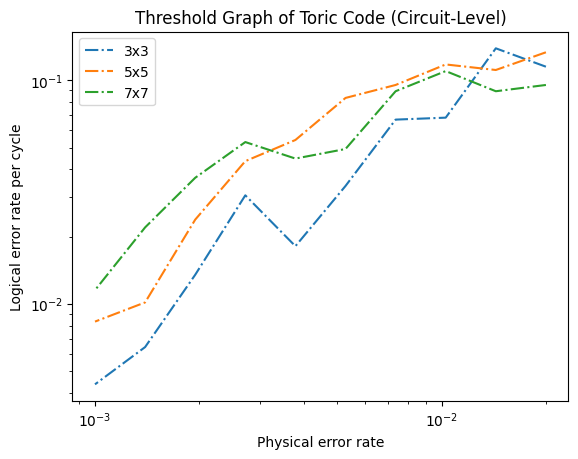

In [16]:
plt.plot(physical_error, 10/(3*results_3), '-.', label='3x3')
plt.plot(physical_error, 10/(5*results_5), '-.', label='5x5')
plt.plot(physical_error, 10/(7*results_7), '-.', label='7x7')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate per cycle')
plt.legend()
plt.title('Threshold Graph of Toric Code (Circuit-Level)');


### Threshold Attempt

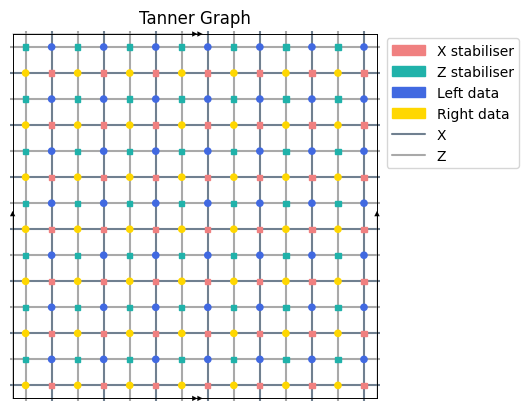

In [ ]:
field = Field(2)
x, y = Monomial(field, 'x'), Monomial(field, 'y')
a, b = 1 - x, 1 - y

bb = BivariateBicycle(a, b, 7, 7, 1)
hx, hz = bb.hx, bb.hz
lx, lz = bb.x_logicals, bb.z_logicals
bb.draw()

x_order = ['Idle', 0, 3, 1, 2]
z_order = [0, 3, 1, 2, 'Idle']

p = 0.01
num_cycles = 2
error_rates = {'Meas': p, 'Prep': p, 'Idle': p, 'CNOT': p}


In [ ]:
# Generate sm circuit and decoding matrix
circ = bb.construct_sm_circuit(x_order, z_order)
hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z = bb.construct_decoding_matrix(circ, error_rates, num_cycles)


In [ ]:
# Generate noisy circ
noisy_circ, err_cnt = bb._generate_noisy_circuit(circ * num_cycles, error_rates)
print(f'Number of errors: {err_cnt}')


Number of errors: 16


In [ ]:
# Simulate noisy circ
x_syndrome_history, x_state, x_syndrome_map, x_err_count = bb._simulate_x_circuit(noisy_circ + circ + circ)
print(f'Number of X errors: {x_err_count}')
print(f'x_syndrome_history: {x_syndrome_history}')


Number of X errors: 9
x_syndrome_history: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# Calculate true logical effect
qudits_dict = bb.qudits_dict
data_qudits = bb.data_qudits
x_state_data_qudits = [x_state[qudits_dict[qudit]] for qudit in data_qudits]
x_syndrome_final_logical = (np.array(lz) @ x_state_data_qudits) % field.p
print(f'True final logical X error: {x_syndrome_final_logical}')


True final logical X error: [0 1]


In [ ]:
# Syndrome sparsification
z_checks = bb.z_checks
x_syndrome_history_copy = x_syndrome_history.copy()
for check in z_checks:
    pos = x_syndrome_map[check]
    assert len(pos) == num_cycles + 2
    for row in range(1, num_cycles + 2):
        x_syndrome_history[pos[row]] += x_syndrome_history_copy[pos[row-1]]
x_syndrome_history %= field.p
print(f'Sparsified x_syndrome_history: {x_syndrome_history}')


Sparsified x_syndrome_history: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# Decode
bposd = BpOsdDecoder(short_hx_eff, error_channel=channel_prob_x, max_iter=1000)
x_error = bposd.decode(x_syndrome_history)
print(f'Decoded X error: {x_error}')
assert np.all((short_hx_eff @ x_error) % field.p == x_syndrome_history)


Decoded X error: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0

In [ ]:
# Check logical effect
first_logical_row = bb.l * bb.m * (num_cycles + 2)
k = len(lx)
x_syndrome_history_augmented_guessed = (hx_eff @ x_error) % field.p
x_syndrome_final_logical_guessed = x_syndrome_history_augmented_guessed[first_logical_row: first_logical_row + k]
print(f'Guessed logical effect: {x_syndrome_final_logical_guessed}')
print(f'Actual logical effect: {x_syndrome_final_logical}')
x_success = np.array_equal(x_syndrome_final_logical_guessed, x_syndrome_final_logical)


Guessed logical effect: [0 0]
Actual logical effect: [0 1]


In [ ]:
physical_error = np.logspace(-1.7, -3, 10)
results = []
print(f'Starting full trials over physical error rates {physical_error}')

for p in physical_error:
    error_rates = {'Meas': p, 'Prep': p, 'Idle': p, 'CNOT': p}
    fails = 0
    trials = 0

    # Generate sm circuit and decoding matrix
    hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z = bb.construct_decoding_matrix(circ, error_rates, num_cycles)

    while fails < 10:
        trials += 1
        
        # Generate noisy circ
        noisy_circ, err_cnt = bb._generate_noisy_circuit(circ * num_cycles, error_rates)
        
        # Simulate noisy circ
        x_syndrome_history, x_state, x_syndrome_map, x_err_count = bb._simulate_x_circuit(noisy_circ + circ + circ)
        
        # Calculate true logical effect
        qudits_dict = bb.qudits_dict
        data_qudits = bb.data_qudits
        x_state_data_qudits = [x_state[qudits_dict[qudit]] for qudit in data_qudits]
        x_syndrome_final_logical = (np.array(lz) @ x_state_data_qudits) % field.p
        
        # Syndrome sparsification
        z_checks = bb.z_checks
        x_syndrome_history_copy = x_syndrome_history.copy()
        for check in z_checks:
            pos = x_syndrome_map[check]
            assert len(pos) == num_cycles + 2
            for row in range(1, num_cycles + 2):
                x_syndrome_history[pos[row]] += x_syndrome_history_copy[pos[row-1]]
        x_syndrome_history %= field.p
        
        # Decode
        bposd = BpOsdDecoder(short_hx_eff, error_channel=channel_prob_x, max_iter=1000)
        x_error = bposd.decode(x_syndrome_history)
        assert np.all((short_hx_eff @ x_error) % field.p == x_syndrome_history)
        
        # Check logical effect
        first_logical_row = bb.l * bb.m * (num_cycles + 2)
        k = len(lx)
        x_syndrome_history_augmented_guessed = (hx_eff @ x_error) % field.p
        x_syndrome_final_logical_guessed = x_syndrome_history_augmented_guessed[first_logical_row: first_logical_row + k]
        
        if not np.array_equal(x_syndrome_final_logical_guessed, x_syndrome_final_logical):
            fails += 1
            print(f'Physical error rate: {p:.4f}, Trial: {trials}, Failures: {fails}')
    print('--------------------------------------------------------------')
    results.append(trials)


Starting full trials over physical error rates [0.01995262 0.01430723 0.01025914 0.00735642 0.005275   0.00378249
 0.00271227 0.00194486 0.00139458 0.001     ]
Physical error rate: 0.0200, Trial: 2, Failures: 1
Physical error rate: 0.0200, Trial: 3, Failures: 2
Physical error rate: 0.0200, Trial: 4, Failures: 3
Physical error rate: 0.0200, Trial: 5, Failures: 4
Physical error rate: 0.0200, Trial: 8, Failures: 5
Physical error rate: 0.0200, Trial: 9, Failures: 6
Physical error rate: 0.0200, Trial: 11, Failures: 7
Physical error rate: 0.0200, Trial: 13, Failures: 8
Physical error rate: 0.0200, Trial: 14, Failures: 9
Physical error rate: 0.0200, Trial: 16, Failures: 10
--------------------------------------------------------------
Physical error rate: 0.0143, Trial: 3, Failures: 1
Physical error rate: 0.0143, Trial: 6, Failures: 2
Physical error rate: 0.0143, Trial: 7, Failures: 3
Physical error rate: 0.0143, Trial: 9, Failures: 4
Physical error rate: 0.0143, Trial: 10, Failures: 5
Physic

In [ ]:
results


[16, 17, 34, 49, 50, 47, 178, 170, 174, 273]

In [ ]:
results_7 = [16, 17, 34, 49, 50, 47, 178, 170, 174, 273]


In [ ]:
results_5 = [16, 28, 25, 53, 82, 141, 191, 419, 198, 504]


In [ ]:
results_3 = np.array([13, 32, 25, 42, 48, 148, 222, 141, 182, 351]) + np.array([19, 18, 16, 61, 93, 54, 83, 312, 104, 548])


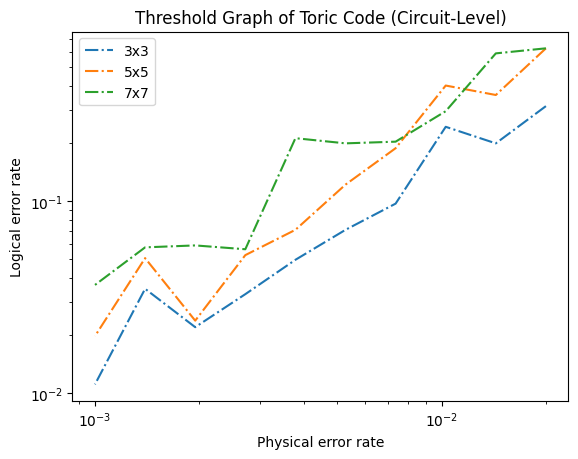

In [ ]:
plt.plot(physical_error, 10/np.array(results_3), '-.', label='3x3')
plt.plot(physical_error, 10/np.array(results_5), '-.', label='5x5')
plt.plot(physical_error, 10/np.array(results_7), '-.', label='7x7')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.legend()
plt.title('Threshold Graph of Toric Code (Circuit-Level)');


### Noise propagation check

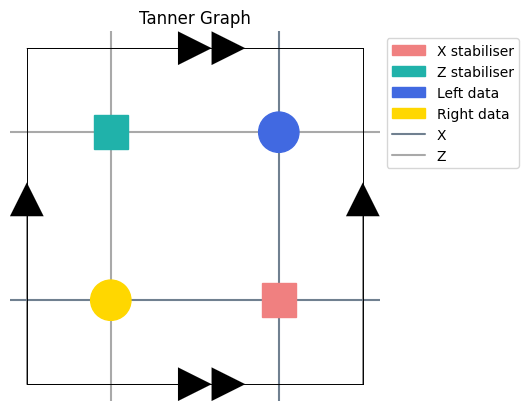

In [ ]:
field = Field(2)
x, y = Monomial(field, 'x'), Monomial(field, 'y')
a, b = 1 - x, 1 - y

bb = BivariateBicycle(a, b, 1, 1, 1)
hx, hz = bb.hx, bb.hz
lx, lz = bb.x_logicals, bb.z_logicals
bb.draw()

x_order = ['Idle', 0, 3, 1, 2]
z_order = [0, 3, 1, 2, 'Idle']

p = 0.01
num_cycles = 2
error_rates = {'Meas': p, 'Prep': p, 'Idle': p, 'CNOT': p}


In [ ]:
circ = bb.construct_sm_circuit(x_order, z_order)
circ


[('Prep_X', ('x_check', 0)),
 ('CNOT', ('data_left', 0), ('z_check', 0), 1),
 ('Idle', ('data_right', 0)),
 ('CNOT', ('x_check', 0), ('data_left', 0), 1),
 ('CNOT', ('data_right', 0), ('z_check', 0), 1),
 ('CNOT', ('x_check', 0), ('data_right', 0), 1),
 ('CNOT', ('data_left', 0), ('z_check', 0), 1),
 ('CNOT', ('x_check', 0), ('data_left', 0), 1),
 ('CNOT', ('data_right', 0), ('z_check', 0), 1),
 ('CNOT', ('x_check', 0), ('data_right', 0), 1),
 ('Meas_Z', ('z_check', 0)),
 ('Idle', ('data_left', 0)),
 ('Idle', ('data_left', 0)),
 ('Idle', ('data_right', 0)),
 ('Meas_X', ('x_check', 0)),
 ('Prep_Z', ('z_check', 0))]

In [ ]:
noise = [
 ('Prep_X', ('x_check', 0)),
 ('CNOT', ('data_left', 0), ('z_check', 0), 1),
 ('X', ('data_left', 0)),
 ('Idle', ('data_right', 0)),
 ('CNOT', ('x_check', 0), ('data_left', 0), 1),
 ('CNOT', ('data_right', 0), ('z_check', 0), 1),
 ('CNOT', ('x_check', 0), ('data_right', 0), 1),
 ('CNOT', ('data_left', 0), ('z_check', 0), 1),
 ('CNOT', ('x_check', 0), ('data_left', 0), 1),
 ('CNOT', ('data_right', 0), ('z_check', 0), 1),
 ('CNOT', ('x_check', 0), ('data_right', 0), 1),
 ('Meas_Z', ('z_check', 0)),
 ('Idle', ('data_left', 0)),
 ('Idle', ('data_left', 0)),
 ('Idle', ('data_right', 0)),
 ('Meas_X', ('x_check', 0)),
 ('Prep_Z', ('z_check', 0))]
noise


[('Prep_X', ('x_check', 0)),
 ('CNOT', ('data_left', 0), ('z_check', 0), 1),
 ('X', ('data_left', 0)),
 ('Idle', ('data_right', 0)),
 ('CNOT', ('x_check', 0), ('data_left', 0), 1),
 ('CNOT', ('data_right', 0), ('z_check', 0), 1),
 ('CNOT', ('x_check', 0), ('data_right', 0), 1),
 ('CNOT', ('data_left', 0), ('z_check', 0), 1),
 ('CNOT', ('x_check', 0), ('data_left', 0), 1),
 ('CNOT', ('data_right', 0), ('z_check', 0), 1),
 ('CNOT', ('x_check', 0), ('data_right', 0), 1),
 ('Meas_Z', ('z_check', 0)),
 ('Idle', ('data_left', 0)),
 ('Idle', ('data_left', 0)),
 ('Idle', ('data_right', 0)),
 ('Meas_X', ('x_check', 0)),
 ('Prep_Z', ('z_check', 0))]

In [ ]:
bb._simulate_x_circuit(noise)


(array([1]), array([0, 1, 0, 0]), {('z_check', 0): [0]}, 1)

In [ ]:
bb.qudits_dict


{('x_check', 0): 0,
 ('data_left', 0): 1,
 ('data_right', 0): 2,
 ('z_check', 0): 3}

In [ ]:
def construct_decoding_matrix(
    self, circ: list, error_rates: dict, num_cycles: int = 1
) -> np.ndarray:
    if not (isinstance(error_rates, dict)):
        raise TypeError("error_rates must be a dictionary")
    for key in error_rates.keys():
        if (key not in ["Meas", "Prep", "Idle", "CNOT"]) or (len(error_rates) != 4):
            raise ValueError(
                "error_rates must have keys ['Meas', 'Prep', 'Idle', 'CNOT']"
            )
        if not (isinstance(error_rates[key], float) and 0 <= error_rates[key] <= 1):
            raise ValueError("error_rates must have values between 0 and 1")
    if not (isinstance(num_cycles, int) and num_cycles > 0):
        raise TypeError("num_cycles must be a positive integer")

    l, m = self.l, self.m
    field = self.field
    qudits_dict, data_qudits = self.qudits_dict, self.data_qudits
    x_logicals, z_logicals = self.x_logicals, self.z_logicals
    x_checks, z_checks = self.x_checks, self.z_checks

    # Construct repeated circuit
    repeated_circ = circ * num_cycles

    # Single error circuits
    z_prob, z_circuit = [], []
    x_prob, x_circuit = [], []
    head = []
    tail = repeated_circ.copy()
    for gate in repeated_circ:
        # assert gate[0] in ['CNOT', 'Idle', 'Meas_X', 'Meas_Z', 'Prep_X', 'Prep_Z']
        if gate[0] == "Meas_X":
            # Meas_X error only affects Z detectors
            z_circuit.append(head + [("Z", gate[1])] + tail)
            z_prob.append(error_rates["Meas"])
        if gate[0] == "Meas_Z":
            # Meas_Z error only affects X detectors
            x_circuit.append(head + [("X", gate[1])] + tail)
            x_prob.append(error_rates["Meas"])
        head.append(gate)
        tail.pop(0)
        # assert repeated_circ == head + tail
        if gate[0] == "Prep_X":
            # Prep_X error only affects Z detectors
            z_circuit.append(head + [("Z", gate[1])] + tail)
            z_prob.append(error_rates["Prep"])
        if gate[0] == "Prep_Z":
            # Prep_Z error only affects X detectors
            x_circuit.append(head + [("X", gate[1])] + tail)
            x_prob.append(error_rates["Prep"])
        if gate[0] == "Idle":
            # Idle error on Z detectors
            z_circuit.append(head + [("Z", gate[1])] + tail)
            z_prob.append(
                error_rates["Idle"] * 2 / 3
            )  # 3 possible Idle errors are X, Y, Z so Z is 2/3 (Y and Z)
            # Idle error on X detectors
            x_circuit.append(head + [("X", gate[1])] + tail)
            x_prob.append(error_rates["Idle"] * 2 / 3)
        if gate[0] == "CNOT":
            # Z error on control
            z_circuit.append(head + [("Z", gate[1])] + tail)
            z_prob.append(
                error_rates["CNOT"] * 4 / 15
            )  # possible CNOT errors are IX, IY, ..., ZZ so Z is 4/15 (IZ, IY, XZ and XY)
            # Z error on target
            z_circuit.append(head + [("Z", gate[2])] + tail)
            z_prob.append(error_rates["CNOT"] * 4 / 15)
            # Z error on both
            z_circuit.append(head + [("ZZ", gate[1], gate[2])] + tail)
            z_prob.append(error_rates["CNOT"] * 4 / 15)
            # X error on control
            x_circuit.append(head + [("X", gate[1])] + tail)
            x_prob.append(error_rates["CNOT"] * 4 / 15)
            # X error on target
            x_circuit.append(head + [("X", gate[2])] + tail)
            x_prob.append(error_rates["CNOT"] * 4 / 15)
            # X error on both
            x_circuit.append(head + [("XX", gate[1], gate[2])] + tail)
            x_prob.append(error_rates["CNOT"] * 4 / 15)

    # Execute each noisy X circuit and compute syndrome
    # Add two noiseless syndrome cycles to end
    cnt = 0
    Hx_dict = {}
    for x_circ in x_circuit:
        syndrome_history, state, syndrome_map, err_cnt = self._simulate_x_circuit(
            x_circ + circ + circ
        )
        assert err_cnt == 1
        assert len(syndrome_history) == l * m * (num_cycles + 2)

        # Compute final state of data qudits and logical effect
        state_data_qudits = [
            state[qudits_dict[qudit]] for qudit in data_qudits
        ]  # 1 indicates X error
        syndrome_final_logical = (
            np.array(z_logicals) @ state_data_qudits
        ) % field.p  # Check if X error flips logical Z outcome

        # Syndrome sparsification, i.e. only keep syndrome entries that change from previous cycle
        syndrome_history_copy = syndrome_history.copy()
        for check in z_checks:
            pos = syndrome_map[check]
            assert len(pos) == num_cycles + 2
            for row in range(1, num_cycles + 2):
                syndrome_history[pos[row]] += syndrome_history_copy[pos[row - 1]]
        syndrome_history %= field.p

        # Combine syndrome_history and syndrome_final_logical
        syndrome_history_augmented = np.hstack(
            [syndrome_history, syndrome_final_logical]
        )

        # Hx_dict maps flagged Z stabilisers to corresponding noisy circuit, i.e. Hx_dict[flagged_z_stab] = [noisy_circuit_1, noisy_circuit_2, ...]
        supp = tuple(np.nonzero(syndrome_history_augmented)[0])
        if supp in Hx_dict:
            Hx_dict[supp].append(cnt)
        else:
            Hx_dict[supp] = [cnt]
        cnt += 1

    first_logical_row_x = l * m * (num_cycles + 2)
    num_x_errors = len(Hx_dict)  # Number of distinct X syndrome histories
    k = len(x_logicals)  # Number of logical qudits
    hx_eff, short_hx_eff = [], []
    channel_prob_x = []
    for supp in Hx_dict:
        new_col = np.zeros(
            (l * m * (num_cycles + 2) + k, 1), dtype=int
        )  # With the augmented part for logicals
        new_col_short = np.zeros((l * m * (num_cycles + 2), 1), dtype=int)
        new_col[list(supp), 0] = 1  # 1 indicates which stabiliser is flagged
        new_col_short[:, 0] = new_col[0:first_logical_row_x, 0]
        hx_eff.append(coo_matrix(new_col))
        short_hx_eff.append(coo_matrix(new_col_short))
        channel_prob_x.append(
            np.sum([x_prob[i] for i in Hx_dict[supp]])
        )  # Probability of a given X syndrome
    hx_eff = hstack(
        hx_eff
    )  # Row = flagged detectors (+ logical effect), column = eror mechanism (with same logical effect)
    short_hx_eff = hstack(
        short_hx_eff
    )  # Shortened hx_eff without rows for logicals

    # Execute each noisy Z circuit and compute syndrome
    # Add two noiseless syndrome cycles to end
    cnt = 0
    Hz_dict = {}
    for z_circ in z_circuit:
        syndrome_history, state, syndrome_map, err_cnt = self._simulate_z_circuit(
            z_circ + circ + circ
        )
        assert err_cnt == 1
        assert len(syndrome_history) == l * m * (num_cycles + 2)

        # Compute final state of data qudits and logical effect
        state_data_qudits = [state[qudits_dict[qudit]] for qudit in data_qudits]
        syndrome_final_logical = (
            np.array(x_logicals) @ state_data_qudits
        ) % field.p

        # Syndrome sparsification, i.e. only keep syndrome entries that change from previous cycle
        syndrome_history_copy = syndrome_history.copy()
        for check in x_checks:
            pos = syndrome_map[check]
            assert len(pos) == num_cycles + 2
            for row in range(1, num_cycles + 2):
                syndrome_history[pos[row]] += syndrome_history_copy[pos[row - 1]]
        syndrome_history %= field.p

        # Combine syndrome_history and syndrome_final_logical
        syndrome_history_augmented = np.hstack(
            [syndrome_history, syndrome_final_logical]
        )

        # Hz_dict maps flagged X stabilisers to corresponding noisy circuit, i.e. Hz_dict[flagged_x_stab] = [noisy_circuit_1, noisy_circuit_2, ...]
        supp = tuple(np.nonzero(syndrome_history_augmented)[0])
        if supp in Hz_dict:
            Hz_dict[supp].append(cnt)
        else:
            Hz_dict[supp] = [cnt]
        cnt += 1

    first_logical_row_z = l * m * (num_cycles + 2)
    num_z_errors = len(Hz_dict)  # Number of distinct Z syndrome histories
    hz_eff, short_hz_eff = [], []
    channel_prob_z = []
    for supp in Hz_dict:
        new_col = np.zeros(
            (l * m * (num_cycles + 2) + k, 1), dtype=int
        )  # With the augmented part for logicals
        new_col_short = np.zeros((l * m * (num_cycles + 2), 1), dtype=int)
        new_col[list(supp), 0] = 1  # 1 indicates which stabiliser is flagged
        new_col_short[:, 0] = new_col[0:first_logical_row_z, 0]
        hz_eff.append(coo_matrix(new_col))
        short_hz_eff.append(coo_matrix(new_col_short))
        channel_prob_z.append(
            np.sum([z_prob[i] for i in Hz_dict[supp]])
        )  # Probability of a given Z syndrome
    hz_eff = hstack(
        hz_eff
    )  # Row = flagged detectors (+ logical effect), column = eror mechanism (with same logical effect)
    short_hz_eff = hstack(
        short_hz_eff
    )  # Shortened hz_eff without rows for logicals

    return ((z_circuit),
        hx_eff,
        short_hx_eff,
        hz_eff,
        short_hz_eff,
        channel_prob_x,
        channel_prob_z,
    )


In [ ]:
circs = construct_decoding_matrix(bb, circ, error_rates, 1)[0]


In [ ]:
len(circs)


30